In [2]:
from PIL import Image
import os, glob
import numpy as np
import random, math

# 画像が保存されているルートディレクトリのパス
root_dir = "image"

# 商品カテゴリ名（ラベル）
categories = ["正誤問題", "文系の数学", "厳選数学", "中堅私大古文",
              "整序問題集", "現代文アクセス発展", "数学思考力",
              "ITパスポート", "Focus Gold", "英文法レベル5"]

# 画像・ラベル格納用
X = []
Y = []

# サンプル作成関数（画像を読み込み配列に追加）
def add_sample(cat, fname):
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((150, 150))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

# データセット作成関数
def make_sample(files):
    global X, Y
    X = []
    Y = []
    for cat, fname in files:
        add_sample(cat, fname)
    return np.array(X), np.array(Y)

# すべてのファイル情報を格納
allfiles = []

for idx, cat in enumerate(categories):
    image_dir = os.path.join(root_dir, cat)
    files = glob.glob(os.path.join(image_dir, "*.png")) + \
            glob.glob(os.path.join(image_dir, "*.jpg")) + \
            glob.glob(os.path.join(image_dir, "*.jpeg"))
    for f in files:
        allfiles.append((idx, f))

# シャッフルして 8:2 に分割
random.shuffle(allfiles)
threshold = math.floor(len(allfiles) * 0.8)
train = allfiles[:threshold]
test = allfiles[threshold:]

# データ生成
X_train, y_train = make_sample(train)
X_test, y_test = make_sample(test)

# 保存ディレクトリがなければ作成
os.makedirs("test", exist_ok=True)

# データ保存（.npz形式で4配列を安全に保存）
np.savez("test/tea_data.npz",
         X_train=X_train, X_test=X_test,
         y_train=y_train, y_test=y_test)


In [3]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation="relu"))
model.add(layers.Dense(10,activation="sigmoid")) #分類先の種類分設定

# モデル構成の確認
model.summary()

C:\Users\iniad\miniconda3\envs\conda\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,457,738 (13.19 MB)

 Trainable params: 3,457,738 (13.19 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# モデルのコンパイル

from keras import optimizers

model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=["acc"])


In [7]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# カテゴリ数の定義
categories = ["正誤問題","文系の数学","厳選数学","中堅私大古文",
              "整序問題集","現代文アクセス発展","数学思考力",
              "ITパスポート","Focus Gold", "英文法レベル5"]

data = np.load("test/tea_data.npz")
X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]

# データの正規化
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test, num_classes=10)


In [8]:
model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=6,
    validation_data=(X_test, y_test)
)


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - acc: 0.1975 - loss: 0.4004 - val_acc: 0.3628 - val_loss: 0.2570
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - acc: 0.6842 - loss: 0.1887 - val_acc: 0.9912 - val_loss: 0.0728
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - acc: 0.9553 - loss: 0.0563 - val_acc: 1.0000 - val_loss: 0.0112
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - acc: 0.9946 - loss: 0.0130 - val_acc: 1.0000 - val_loss: 0.0016
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - acc: 0.9968 - loss: 0.0057 - val_acc: 1.0000 - val_loss: 5.4134e-04
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - acc: 1.0000 - loss: 3.9158e-04 - val_acc: 1.0000 - val_loss: 1.6589e-04
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - acc: 1.0000 - loss: 1.3333e-04 - val_acc: 1.0000 - val_loss: 8.7911e-05
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - acc: 1.0000 - loss: 7.8296e-05 - val_acc: 1.0000 - val_loss: 5.4322e-05
Epoch 9/10
76/76 ━━━

In [9]:
print(X_train.shape)  # → (データ数, 150, 150, 3)
print(y_train.shape)

(452, 150, 150, 3)
(452, 10)


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - acc: 1.0000 - loss: 9.1020e-06 - val_acc: 1.0000 - val_loss: 8.4558e-06
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - acc: 1.0000 - loss: 7.9266e-06 - val_acc: 1.0000 - val_loss: 7.9139e-06
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - acc: 1.0000 - loss: 7.5475e-06 - val_acc: 1.0000 - val_loss: 7.4318e-06
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - acc: 1.0000 - loss: 6.9626e-06 - val_acc: 1.0000 - val_loss: 6.9786e-06
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - acc: 1.0000 - loss: 6.1717e-06 - val_acc: 1.0000 - val_loss: 6.5553e-06
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - acc: 1.0000 - loss: 6.3125e-06 - val_acc: 1.0000 - val_loss: 6.2153e-06
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - acc: 1.0000 - loss: 5.5135e-06 - val_acc: 1.0000 - val_loss: 5.8922e-06
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - acc: 1.0000 - loss: 5.3229e-06 - val_acc: 1.0000 - val_loss: 

C:\Users\iniad\miniconda3\envs\conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\iniad\miniconda3\envs\conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\iniad\miniconda3\envs\conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\iniad\miniconda3\envs\conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\iniad\miniconda3\envs\conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12487 (\N{KATAKANA

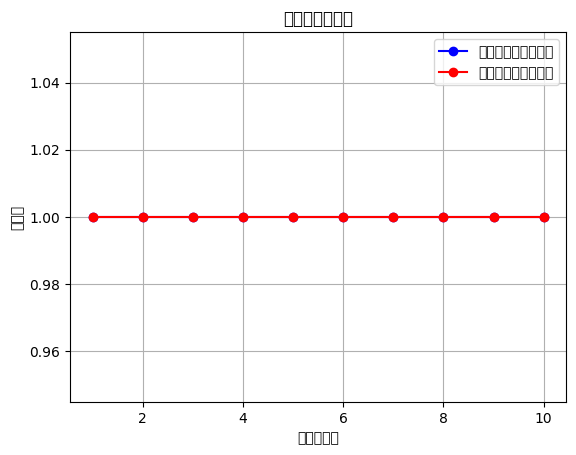

C:\Users\iniad\miniconda3\envs\conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\iniad\miniconda3\envs\conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


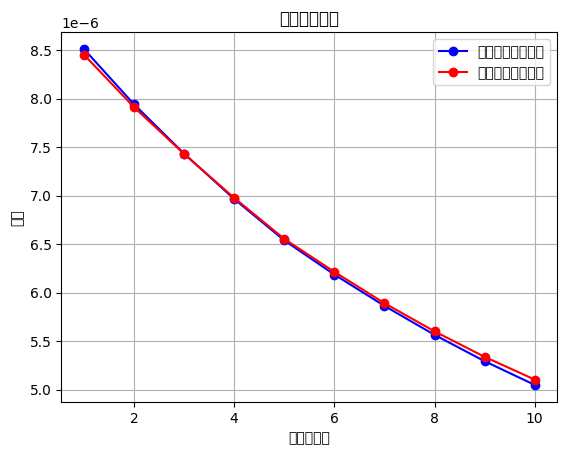

In [12]:
# モデル学習
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=6,
    validation_data=(X_test, y_test)
)

# 学習結果を取り出す
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# グラフ表示
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='訓練データの正解率')
plt.plot(epochs, val_acc, 'ro-', label='検証データの正解率')
plt.title('モデルの正解率')
plt.xlabel('エポック数')
plt.ylabel('正解率')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, loss, 'bo-', label='訓練データの損失')
plt.plot(epochs, val_loss, 'ro-', label='検証データの損失')
plt.title('モデルの損失')
plt.xlabel('エポック数')
plt.ylabel('損失')
plt.legend()
plt.grid()
plt.show()


In [16]:
# モデルの構造をJSON形式で保存
json_string = model.to_json()
with open('test/tea_predict.json', 'w') as json_file:
    json_file.write(json_string)

# 重みをHDF5形式で保存
model.save_weights('test/tea_predict.weights.h5')


In [17]:
from PIL import Image
import os, glob
import numpy as np
import random, math

# 画像が保存されているディレクトリのパス
root_dir = "image"
# 画像が保存されているフォルダ名
categories = ["正誤問題","文系の数学","厳選数学","中堅私大古文",
              "整序問題集","現代文アクセス発展","数学思考力",
              "ITパスポート","Focus Gold", "英文法レベル5"]

X = [] # 画像データ
Y = [] # ラベルデータ

# フォルダごとに分けられたファイルを収集
# （categoriesのidxと、画像のファイルパスが紐づいたリストを生成）
allfiles = []
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(os.path.join(image_dir, "*.png")) + \
            glob.glob(os.path.join(image_dir, "*.jpg")) + \
            glob.glob(os.path.join(image_dir, "*.jpeg"))
    for f in files:
        allfiles.append((idx, f))

for cat, fname in allfiles:
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((150, 150))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

x = np.array(X)
y = np.array(Y)

np.save("test/tea_data_test_X_150.npy", x)
np.save("test/tea_data_test_Y_150.npy", y)


In [21]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# 評価用のデータの読み込み
eval_X = np.load("test/tea_data_test_X_150.npy")
eval_Y = np.load("test/tea_data_test_Y_150.npy")

# Yのデータをone-hotに変換
eval_Y = to_categorical(eval_Y, num_classes=10)

# モデルの評価
score = model.evaluate(x=eval_X, y=eval_Y)

# 結果を表示
print('loss =', score[0])
print('accuracy =', score[1])


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - acc: 1.0000 - loss: 0.0000e+00
loss = 0.0
accuracy = 1.0


In [5]:
from keras.models import model_from_json
from keras.preprocessing import image
import numpy as np

# モデルの読み込み
with open('test/tea_predict.json', 'r') as json_file:
    model = model_from_json(json_file.read())
model.load_weights('test/tea_predict.weights.h5')  # 拡張子注意

# カテゴリ名
categories = ["正誤問題", "文系の数学", "厳選数学", "中堅私大古文",
              "整序問題集", "現代文アクセス発展", "数学思考力",
              "ITパスポート", "Focus Gold", "英文法レベル5"]

# 画像の読み込みと前処理
img_path = input("画像ファイルパスを入力してください：")
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x.astype('float32') / 255.0  # 正規化

# 予測
features = model.predict(x)
predicted_index = np.argmax(features[0])
confidence = features[0][predicted_index]  # 予測確率
predicted_label = categories[predicted_index]

# しきい値を設定（例：0.5）
threshold = 0.5

# 判定表示
if confidence < threshold:
    print(f"この画像は、どのカテゴリにも確信を持って分類できませんでした。（信頼度：{confidence:.2f}）")
else:
    print(f"この画像は「{predicted_label}」と予測されました。（信頼度：{confidence:.2f}）")

    if predicted_index in [0, 4, 9]:  # 英文法レベル5
        print("その参考書は、英語です。")
    elif predicted_index in [1, 2, 6, 8]:  # 数学関連（文系の数学, 厳選数学, 数学思考力）
        print("その参考書は、数学です。")
    elif predicted_index in [3, 5]:
        print("その参考書は、国語です。")
    elif predicted_index == 7:
        print("その参考書は、ITパスポートです。")
    else:
        message = f"参考書を選んでください。（もしかして：あなたが選んでいるのは「{predicted_label}」ではありませんか？）"
        print(message)


画像ファイルパスを入力してください： syusyoku.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
この画像は「厳選数学」と予測されました。（信頼度：1.00）
その参考書は、数学です。
